In [1]:
from preprocessing import *
from feature_extraction import *
import torch
from torch import nn, optim
from classifier import nn_train, nn_predict, nn_accuracy
from torchvision import datasets, transforms, models
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [110]:
X, Y = load_data()
print(X.shape)
print(Y.shape)
print(X[0])
print(Y[0])

(1684,)
(1684,)
ACdata_base/1/0001.jpg
1


In [119]:
split_data(X, Y)

In [55]:
class Preprocessing(object):
    def __call__(self,img):
        binaryImage = preprocessImage(np.asarray(img.convert('L')))
        return binaryImage


class FeatureExtraction(object):
    def __call__(self,img):
        featuresLPQ = localPhaseQuantization(img)
        
        featuresNo = 36
#         _, diacritics =  diacriticsSegmentationClustering(img)
#         featuresH = np.zeros((featuresNo))
        
#         if diacritics.sum() != diacritics.size:
        featuresH = extract_EOH(img, featuresNo)
        
        features = np.hstack((featuresH, featuresLPQ))
        return features


train_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])
valid_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])
test_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])

train_data = np.array(datasets.ImageFolder('data/train', transform=train_transforms), dtype=object)
X_train, Y_train = np.stack(train_data[:, 0]), train_data[:, 1].astype(np.uint8)
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)

valid_data = np.array(datasets.ImageFolder('data/valid', transform=valid_transforms), dtype=object)
X_valid, Y_valid = np.stack(valid_data[:, 0]), valid_data[:, 1].astype(np.uint8)
X_valid = torch.from_numpy(X_valid)
Y_valid = torch.from_numpy(Y_valid)

test_data = np.array(datasets.ImageFolder('data/test', transform=test_transforms), dtype=object)
X_test, Y_test = np.stack(test_data[:, 0]), test_data[:, 1].astype(np.uint8)
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([1010, 291])
torch.Size([1010])
torch.Size([337, 291])
torch.Size([337])
torch.Size([337, 291])
torch.Size([337])


[INFO] Epoch: 1/5000
 Training Loss: 0.002, training accuracy 10.990% validation Loss: 0.007, validation accuracy 10.682%
[INFO] Epoch: 101/5000
 Training Loss: 0.001, training accuracy 56.931% validation Loss: 0.003, validation accuracy 59.347%
[INFO] Epoch: 201/5000
 Training Loss: 0.001, training accuracy 79.703% validation Loss: 0.002, validation accuracy 79.228%
[INFO] Epoch: 301/5000
 Training Loss: 0.000, training accuracy 87.921% validation Loss: 0.001, validation accuracy 86.944%
[INFO] Epoch: 401/5000
 Training Loss: 0.000, training accuracy 91.287% validation Loss: 0.001, validation accuracy 90.801%
[INFO] Epoch: 501/5000
 Training Loss: 0.000, training accuracy 94.059% validation Loss: 0.001, validation accuracy 95.252%
[INFO] Epoch: 601/5000
 Training Loss: 0.000, training accuracy 96.436% validation Loss: 0.000, validation accuracy 96.142%
[INFO] Epoch: 701/5000
 Training Loss: 0.000, training accuracy 97.327% validation Loss: 0.000, validation accuracy 96.439%
[INFO] Epo

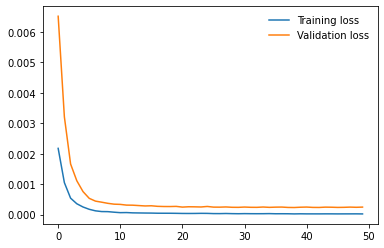

In [57]:
model = nn.Sequential(nn.Linear(291, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(512, 9),
                    nn.LogSoftmax(dim=1))

train_losses, validation_losses =\
    nn_train(model, X_train, Y_train, X_valid, Y_valid, epochs=5000, lr=0.001, validate_every=100, debug=True)

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [71]:
# torch.save(model.state_dict(), 'model.pth')
# model.load_state_dict(torch.load('model.pth'))

train_predictions = nn_predict(model, X_train)
validation_predictions = nn_predict(model, X_valid)
test_predictions = nn_predict(model, X_test)

training_accuracy, training_correct = nn_accuracy(train_predictions, Y_train)
validation_accuracy, validation_correct = nn_accuracy(validation_predictions, Y_valid)
test_accuracy, test_correct = nn_accuracy(test_predictions, Y_test)

print(f'training accuracy = {training_accuracy*100}%   ({training_correct}/{len(Y_train)})')
print(f'validation accuracy = {validation_accuracy*100}%   ({validation_correct}/{len(Y_valid)})')
print(f'test accuracy = {test_accuracy*100}%   ({test_correct}/{len(Y_test)})')

training accuracy = 100.0%   (1010/1010)
validation accuracy = 98.81305637982196%   (333/337)
test accuracy = 99.10979228486647%   (334/337)


In [67]:
for i in range(9):
    print('[INFO]')
    print(f'class #{i+1}')

    training_accuracy, training_correct = nn_accuracy(train_predictions[Y_train == i], Y_train[Y_train == i])
    validation_accuracy, validation_correct = nn_accuracy(validation_predictions[Y_valid == i], Y_valid[Y_valid == i])
    test_accuracy, test_correct = nn_accuracy(test_predictions[Y_test == i], Y_test[Y_test == i])

    print(f'training accuracy = {training_accuracy*100:0.3f}%   ({training_correct}/{len(Y_train[Y_train == i])})')
    print(f'validation accuracy = {validation_accuracy*100:0.3f}%   ({validation_correct}/{len(Y_valid[Y_valid == i])})')
    print(f'test accuracy = {test_accuracy*100:0.3f}%   ({test_correct}/{len(Y_test[Y_test == i])})')
    
    print()

[INFO]
class #1
training accuracy = 100.000%   (124/124)
validation accuracy = 100.000%   (36/36)
test accuracy = 100.000%   (30/30)

[INFO]
class #2
training accuracy = 100.000%   (109/109)
validation accuracy = 100.000%   (43/43)
test accuracy = 100.000%   (38/38)

[INFO]
class #3
training accuracy = 100.000%   (111/111)
validation accuracy = 100.000%   (40/40)
test accuracy = 100.000%   (28/28)

[INFO]
class #4
training accuracy = 100.000%   (117/117)
validation accuracy = 96.429%   (27/28)
test accuracy = 97.500%   (39/40)

[INFO]
class #5
training accuracy = 100.000%   (117/117)
validation accuracy = 97.436%   (38/39)
test accuracy = 97.436%   (38/39)

[INFO]
class #6
training accuracy = 100.000%   (95/95)
validation accuracy = 97.436%   (38/39)
test accuracy = 100.000%   (46/46)

[INFO]
class #7
training accuracy = 100.000%   (106/106)
validation accuracy = 100.000%   (38/38)
test accuracy = 100.000%   (41/41)

[INFO]
class #8
training accuracy = 100.000%   (121/121)
validation a